Тестирование работы сверточного вариационного автоэнкодера без дополнительного входа номера класса. Визуализация 2мерного скрытого пространства, тест генерации, тест восстановления.

Возьмите из ноутбука по практическому занятия "Автокодировщики" сверточный вариационный энкодер и обучите его на датасете Emnist letters. Датасет содержит изображения рукописных латинских букв. Размер обучающей выборки 697932 изображенй, тестовой - 116323. Установите размер скрытого пространства равным 2.
В работе
1. определите использование скрытого пространства АЕ на всех классах датасета
2. качество генерации букв декодером
3. качество восстановления букв автокодировщиком 

In [ ]:
# Установим модуль для загрузки EMNIST
!pip install emnist

In [ ]:
# Подключим Numpy
import numpy as np

# Подключим библиотеку отображения графиков
import matplotlib.pyplot as plt

# Импортируем Keras
from tensorflow import keras

import tensorflow as tf

# Подключим все необходимые слои Keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Conv2D, Conv2DTranspose

# Подключим модуль вычислений на Keras
import keras.backend as K

# Подключим датасет рукописных букв
from emnist import extract_training_samples, extract_test_samples  

# Подключим модуль работы с операционной системой
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # От tensorflow будет получать только ошибки

In [ ]:
hidden_dim = 2  # Зададим размерность скрытого пространства AE
batch_size = 100 # Задамим размер батча для обучения AE

In [ ]:
# Скачаем обучающую выборку
xs_train, y_train = extract_training_samples('letters')

# Скачаем тестовую выборку
xs_test, y_test = extract_test_samples('letters')

# Добавим 1 размерность numpy-массиву обучающей выборки + приведем к диапазону 0...1
x_train = np.reshape(xs_train, (len(xs_train), 28, 28, 1))/255. 

# Добавим 1 размерность numpy-массиву тестовой выборки + приведем к диапазону 0...1
x_test = np.reshape(xs_test, (len(xs_test), 28, 28, 1))/255.  

In [ ]:
# Создадим функцию вывод 100 элементов обучающей выборки

def showResult(viz):                                                  # Получим набор изображений
                                                            
    total = 10                                                        # Полное количесво выводимых цифр
    plt.figure(figsize=(total, total))                                # Создаем заготовку для финальной картинки 
    num = 1                                                           # Счетчик выводимых цифр
    for i in range(0, 100):                                           # Цикл по графикам
        ax = plt.subplot(total, total, num)                           # Добавим место для графика
        img = viz[num-1,:,:,:]                                        # Вывыбираем очередной график
        num += 1                                                      # Инкремент номера графика        
        plt.imshow(img.squeeze(), cmap='gray')                        # Рисуем предсказанную цифру
        ax.get_xaxis().set_visible(False)                             # Спрячем ось X
        ax.get_yaxis().set_visible(False)                             # Спрячем ось Y

In [ ]:
print (x_train.shape) # Выведем размерность обучающей выборки изображений
print (x_test.shape)  # Выведем размерность тестовой выборки изображений
print (y_train.shape) # Выведем размерность обучающей выборки меток
print (y_test.shape)  # Выведем размерность тестовой выборки меток


(124800, 28, 28, 1)
(20800, 28, 28, 1)
(124800,)
(20800,)


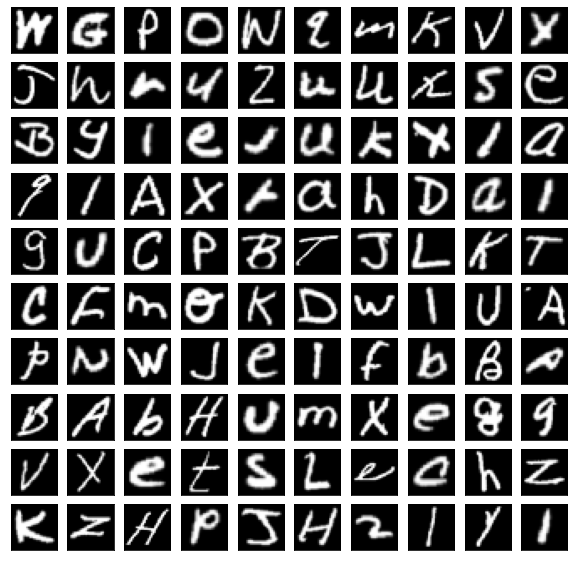

In [ ]:
# Взглянем на первые 100 изображений обучающей выборки

showResult(x_train[:100,:,:,:])

In [ ]:
# Взглянем на первые 100 меток обучающей выборки

y_train[:100]

array([23,  7, 16, 15, 23, 17, 13, 11, 22, 24, 10, 14, 18, 21, 26, 21, 21,
       24, 19,  5,  2, 25,  9,  5, 10, 21, 11, 24, 12,  1, 17,  9,  1, 24,
       18,  1,  8,  4,  1,  9,  7, 21,  3, 16,  2, 20, 10, 12, 11, 20,  3,
        6, 13, 15, 11,  4, 23, 12, 21,  1, 16, 14, 23, 10,  5, 12,  6,  2,
        2,  1,  2,  1,  2,  8, 21, 13, 24,  5,  7,  7, 22, 24,  5, 20, 19,
       12,  5,  3,  8, 26, 11, 26,  8, 16, 10,  8, 26, 12, 25,  9],
      dtype=uint8)

In [ ]:
# Ваше решение

In [ ]:
# Создадим функцию сборки блока построения сверточного энкодера

def encoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагом сверточного слоя

    # Составим блок сети
    x = Conv2D(neu, kernel_size=kernel, strides= strides, padding='same')(xin) # Добавим 2D свертку
    x = BatchNormalization()(x)                                                # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                         # Добавим функцию активации

    # Вернем выходной тензор
    return x


In [ ]:
# Создадим функцию сборки блока построения сверточного декодера

def decoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагом сверточного слоя

    # Составим блок сети
    x = Conv2DTranspose(neu, kernel_size=kernel, strides= strides, padding='same')(xin)  # Добавим обратную 2D свертку
    x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                                   # Добавим функцию активации

    # Вернем выходной тензор
    return x

In [ ]:
# Создадим сверточный энкодер

input_img = Input(shape=(28, 28, 1))                     # Добавим входной слой
x = encoderBlock(input_img, neu=32, kernel=3, strides=1) # Добавим 1-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 2-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2)         # Добавим 3-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=1)         # Добавим 4-й блок свертка+нормализация+активашка
flatten =Flatten()(x)                                    # Добавим Flatten
x = Dense(hidden_dim, activation='linear')(flatten)               # Добавим выходной dense слой

In [ ]:
z_mean = Dense(hidden_dim)(x)        # Добавим dense для получения мат.ожидания
z_log_var = Dense(hidden_dim)(x)     # Добавим dense для получения логарифма дисперсии

In [ ]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                          # Входные параметры
  z_mean, z_log_var = args                                                 # Разберем входные параметры на отдельные переменные
  N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.0) # Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean                                 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])        # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
                                                                           # На выходе - тензор случайных чисел 

In [ ]:
 # Соберем энкодер

encoderVAEС = keras.Model(input_img, [z_mean, z_log_var, h], name='encoder')

In [ ]:
# Создадим сверточный декодер

input_enc = Input(shape=(hidden_dim,))                            # Добавим входной слой
d = Dense(3136, name='dense_1')(input_enc)               # Добавим dense в 7х7х64 = 3136 нейронами
d = Reshape((7, 7, 64))(d)                               # Решейпим 1D тензор в 3D тензор
d= decoderBlock(d, neu=64, kernel=3, strides=1)          # Добавим 1-й блок обратная свертка+нормализация+активашка
d= decoderBlock(d, neu=64, kernel=3, strides=2)          # Добавим 2-й блок обратная свертка+нормализация+активашка
d= decoderBlock(d, neu=32, kernel=3, strides=2)          # Добавим 3-й блок обратная свертка+нормализация+активашка

decoded = Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(d)# Добавим выходной слой

In [ ]:
# Соберем декодер

decoderVAEС = keras.Model(input_enc, decoded, name='decoder')  

In [ ]:
# Запишем выражение для декодера, заметим, что за вход декодера подается только 1 их выходов энкодера

outputs = decoderVAEС(encoderVAEС(input_img)[2]) 

In [ ]:
# Соберем наши сетки

vaec = keras.Model(input_img, decoderVAEС(encoderVAEС(input_img)[2])) # Соберем VAE

In [ ]:
reconstruction_loss = keras.losses.MSE(input_img, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 28*28                                   # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #  
vaeс_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)      # Суммируем лоссы - здесь можно вводить веса  
vaec.add_loss(vaeс_loss)                                         # Отдадим наш лосс VAE

In [ ]:
# Выведем состав энкодера
encoderVAEС.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 28, 28, 32)   320         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 28, 28, 32)  128         ['conv2d_8[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 28, 28, 32)   0           ['batch_normalization_17[0]

In [ ]:
#  Выведем состав энкодера
decoderVAEС.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 7, 7, 64)         36928     
 ranspose)                                                       
                                                                 
 batch_normalization_21 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 7, 7, 64)          0   

In [ ]:
# Компилируем VAE
vaec.compile(optimizer='adam')

In [ ]:
vaec.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          99854       ['input_6[0][0]',                
                                 (None, 2),                       'input_6[0][0]']                
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    102657      ['encoder[0][2]',                
                                                                  'encoder[1][2]']          

In [ ]:
# Запускаем обучениe

vaec.fit(x_train,      # Обучающая выборка
        x_train,       # "Labels" обучающей выборки
        epochs=10,      # 10 эпох
        batch_size=128, # размер батча
        shuffle=True)  # обучающую выборку перемешиваем


Epoch 1/10
975/975 [==============================] - 67s 66ms/step - loss: 60.2332
Epoch 2/10
975/975 [==============================] - 65s 66ms/step - loss: 56.3917
Epoch 3/10
975/975 [==============================] - 65s 67ms/step - loss: 55.3339
Epoch 4/10
975/975 [==============================] - 65s 67ms/step - loss: 54.5903
Epoch 5/10
975/975 [==============================] - 65s 67ms/step - loss: 53.9595
Epoch 6/10
975/975 [==============================] - 64s 66ms/step - loss: 53.5691
Epoch 7/10
975/975 [==============================] - 64s 66ms/step - loss: 53.2877
Epoch 8/10
975/975 [==============================] - 65s 66ms/step - loss: 53.0150
Epoch 9/10
975/975 [==============================] - 65s 66ms/step - loss: 52.8272
Epoch 10/10
975/975 [==============================] - 65s 66ms/step - loss: 52.6664


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Пересохранение обученной модели полностью (веса и архитектура)
vaec.save('/content/drive/MyDrive/NN/model_vaec_emnist.h5',save_format="tf")

ValueError: ignored

In [ ]:
import keras
vaec=keras.models.load_model('/content/drive/MyDrive/NN/model_vaec_emnist.h5')

KeyError: ignored

Скрытое пространство автоэнкодера, разные цвета соответствуют разным классам.

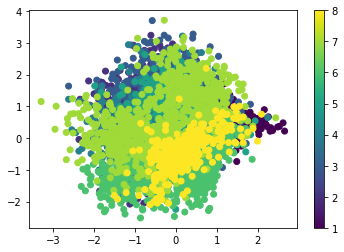

In [ ]:
h = encoderVAEС.predict(x_test[:6000], batch_size=batch_size)    # Предиктим энкодером первые 6000 цизображений ифр 
plt.scatter(h[2][:, 0], h[2][:, 1] , c=y_test[:6000], cmap='viridis') # Выводим  скаттер координат точек скрытого пространства
plt.colorbar()                                                  # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()                                                      # Отрисуем картинку

In [ ]:
# Определим функцию отображения результатов работы декодера

def showResult(decoder): # Получим обученный декодер

    n = 5                                                               
    total = 2*n+1                                                     # Считаем полное количесво выводимых цифр +1
    plt.figure(figsize=(total, total))                                # Создаем заготовку для финальной картинки 
    num = 1                                                           # Счетчик выводимых цифр
    for i in range(-n, n+1):                                          # Цикл по горизонтали пространства Z
     for j in range(-n, n+1):                                         # Цикл по вертикали пространства Z
        ax = plt.subplot(total, total, num)                           # Добавим место для графика
        num += 1                                                      # Инкремент номера графика
        img = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0)) # Выполним предикт изображения цифры по точкам из Z области
        plt.imshow(img.squeeze(), cmap='gray')                        # Рисуем предсказанную цифру
        ax.get_xaxis().set_visible(False)                             # Спрячем ось X
        ax.get_yaxis().set_visible(False)                             # Спрячем ось Y

Генерация изображения буквы декодером автоэнкодера, при разных положениях точки в скрытом пространстве.

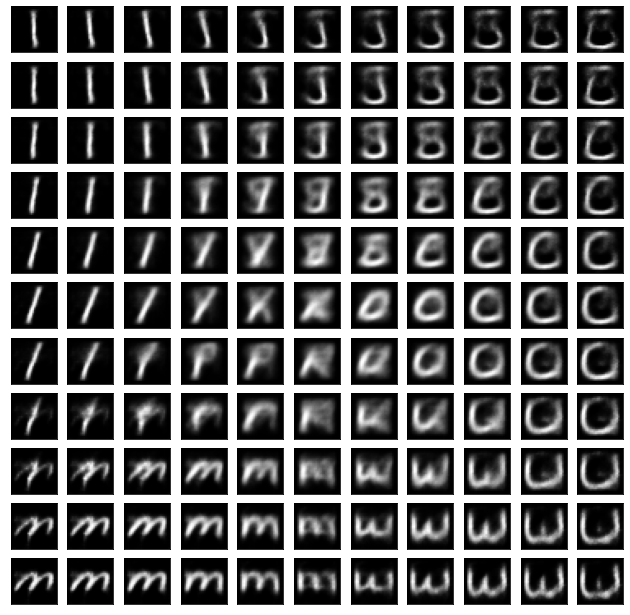

In [ ]:
showResult(decoderVAEС)

Проверка очистки и восстановления.

In [ ]:
# Определим функцию отображения массива
def showArray(ArrayX): # Получим обученный декодер
    n = 10                                                              
    plt.figure(figsize=(n, n))                                # Создаем заготовку для финальной картинки 
    cnt=0
    for i in range(0, n):                                          # Цикл по горизонтали пространства Z
     for j in range(0,n):                                         # Цикл по вертикали пространства Z
        ax = plt.subplot(n, n, cnt+1)                           # Добавим место для графика
        img = ArrayX[cnt]
        cnt += 1                                                      # Инкремент номера графика
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)                             # Спрячем ось X
        ax.get_yaxis().set_visible(False)                             # Спрячем ось Y

In [ ]:
import random
RandomIndex=np.array(range(x_test.shape[0]))
random.shuffle(RandomIndex)

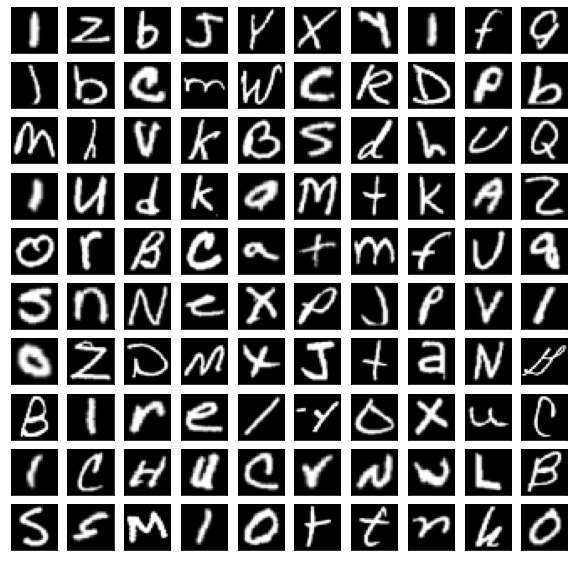

In [ ]:
showArray(x_test[RandomIndex][:100,:,:,:])

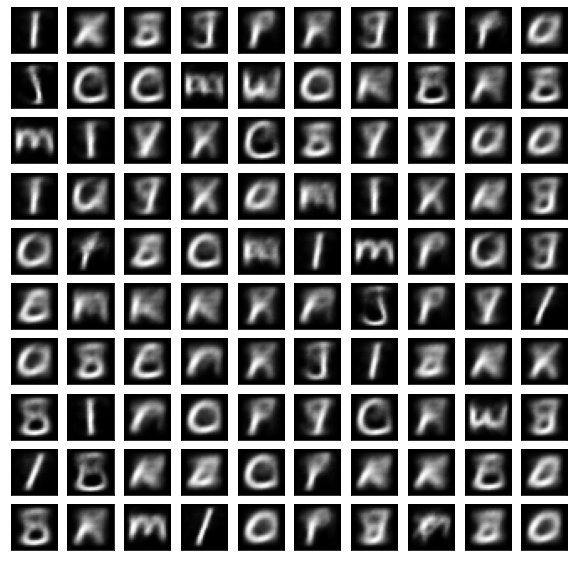

In [ ]:
 showArray(vaec.predict(x_test[RandomIndex][:100]))

Результат восстановления посредственный, без дополнительного входа номера класса вариационный автоэнкодер работает хуже обычного.